# MNIST Calculator

This notebook can be used to reproduce all the experiments for the paper _Performing arithmetic using a neural network trained on combinations of hand written digits_. 

First we import the packages we require, including scikit-learn and Keras. 

In [1]:
# Keras imports for the convolutional neural network for later.
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import losses
from keras import optimizers
from keras import callbacks

# Additional packages
from PIL import Image
import glob
import os
import numpy as np
from sklearn import utils  # Used for utils.shuffle() that can shuffle data + labels in unison.
from sklearn.model_selection import KFold
from tabulate import tabulate
import IPython.display as dp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 6)
%matplotlib inline
from scipy.stats import itemfreq
from math import floor, ceil

# We can set a seed so that those wishing to reproduce the experiment
import random
#random.seed(376483)

Using TensorFlow backend.


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## Load and Generate Training and Test Data

We will use scikit-learn's built-in MNIST data for generating the data for these experiments.

In [2]:
(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = mnist.load_data()

We can take a look at an image from the dataset like so

In [3]:
Image.fromarray(X_train_keras[0])

MNIST images are $28 \times 28$ pixels in size, and the combined images that will be used for training and testing will be two MNIST images placed side by side. The dimensions of a single MNIST image can be seen as follows:

In [4]:
X_train_keras[0].shape

(28, 28)

Therefore, the images used in this experiment will be $28 \times 56$ in size. 

To demonstrate how the combined images look, we can make a random combination and display it inline. First we create an empty $28 \times 56$ image matrix and then populate it with two images from the training set:

In [3]:
# Create an empty 28 * 56 element matrix:
test_image = np.zeros((28,56), dtype="uint8")

# Populate the empty matrix with data from two image matrices from the training set:
test_image[:,:28] = X_train_keras[0]
test_image[:,28:] = X_train_keras[1]
Image.fromarray(test_image)

As can be seen, to generate the data we merely combine two MNIST images into one image.

Now we generate our trainging pairs and test pairs indices. 

For the digits 0-9, there are 100 possible combinations of digits. More formally, we can say that the left side image can consist of the digits 0-9: $S_l = \{0,1,2,3,4,5,6,7,8,9\}$ and the right side consist of images from the set $S_r = \{0,1,2,3,4,5,6,7,8,9\}$. The total possible number of combinations is the Cartesian product of the two sets $D = S_l \times S_r$. 

Here we first generate all possible pairs of combinations and then randomly select 90% of these for the training set and the remainign 10% are used for the test set.

In [4]:
# Generate the 100 unique pairs
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]

# Create 10 test set pairs
test_set_pairs = []

while(len(test_set_pairs) < 10):
    pair_to_add = random.choice(unique_pairs)
    if pair_to_add not in test_set_pairs:
        test_set_pairs.append(pair_to_add)

#Use the remaining 90 as training set pairs
train_set_pairs = list(set(unique_pairs) - set(test_set_pairs))

We can view the test set and training set pairs to ensure there is no overlap between the two data sets. These will be used later to generate the training and test data (they will be used as indices).

The test looks as follows:

In [7]:
print(test_set_pairs)

['51', '02', '30', '65', '97', '95', '98', '82', '54', '34']


In [8]:
print(train_set_pairs)

['24', '25', '26', '27', '20', '21', '22', '23', '28', '29', '59', '58', '55', '57', '56', '50', '53', '52', '88', '89', '83', '80', '81', '86', '87', '84', '85', '03', '00', '01', '06', '07', '04', '05', '08', '09', '39', '38', '33', '32', '31', '37', '36', '35', '60', '61', '62', '63', '64', '66', '67', '68', '69', '99', '91', '90', '93', '92', '94', '96', '11', '10', '13', '12', '15', '14', '17', '16', '19', '18', '48', '49', '46', '47', '44', '45', '42', '43', '40', '41', '77', '76', '75', '74', '73', '72', '71', '70', '79', '78']


In [9]:
print(unique_pairs)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


## Ten Fold Cross Validation

Perform a 10-fold cross validation of the experiment. 

In [10]:
unique_pairs = [str(x)+str(y) for x in range(10) for y in range(10)]
train_counter = 0

(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = mnist.load_data()

kf = KFold(n_splits=10, shuffle=True, random_state=376483)
kf.get_n_splits(unique_pairs)

unique_pairs_np = np.asarray(unique_pairs)
# Store network performance history and score for each of the 10 training runs.
histories = []
scores = []

# Store accuracies measured in various ways
accuracies_rounded = []
accuracies_floor_ceil = []
accuracies_leeway = []


for train_index, test_index in kf.split(unique_pairs):
    test_set_pairs = unique_pairs_np[test_index]
    train_set_pairs = unique_pairs_np[train_index]
    
    # Sanity checks
    assert(len(test_set_pairs) == 10)
    assert(len(train_set_pairs) == 90)
    for test_set_pair in test_set_pairs:
        assert(test_set_pair not in train_set_pairs)
    
    # If these pass we are good to go with data generation
    X_train = []
    y_train = []

    # Number of samples per permutation (e.g. there are 90 permutations in the train 
    # set so 1000*90 makes 90,000 training samples and 10*1000=10,000 test samples)
    samples_per_permutation = 2000  

    for train_set_pair in train_set_pairs:
        for _ in range(samples_per_permutation):
            rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
            rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        
            temp_image = np.zeros((28,56), dtype="uint8")
            temp_image[:,:28] = X_train_keras[rand_i]
            temp_image[:,28:] = X_train_keras[rand_j]

            X_train.append(temp_image)
            y_train.append(y_train_keras[rand_i] + y_train_keras[rand_j])
        
    X_test = []
    y_test = []

    samples_per_permutation = 1000
    
    for test_set_pair in test_set_pairs:
        for _ in range(samples_per_permutation):
            rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
            rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        
            temp_image = np.zeros((28,56), dtype="uint8")
            temp_image[:,:28] = X_test_keras[rand_i]
            temp_image[:,28:] = X_test_keras[rand_j]
            
            X_test.append(temp_image)
            y_test.append(y_test_keras[rand_i] + y_test_keras[rand_j])
    
    
    # Explicitly convert to Numpy arrays, as everything will expect them later
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    # Reshape the data sets to a format suitable for Keras
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    # Some standard preprocessing things here.
    # Reformat the images to use floating point values rather than integers between 0-255
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    # Shuffling is always wise
    X_train, y_train = utils.shuffle(X_train, y_train)
    X_test, y_test = utils.shuffle(X_test, y_test)
    
    ######################################################
    # NETWORK SETUP AND TRAINING
    ######################################################
    # Set up a few constants related to the size of the 
    # network, number of output classes and so on.
    batch_size = 128
    # This is a regression problem and we will 
    # use a single neuron as output: this network is not 
    # being trained as a classification problem.
    num_classes = 1               
    epochs = 100
    img_rows, img_cols = np.shape(X_train)[1], np.shape(X_train)[2]
    input_shape = (img_rows, img_cols, 1)

    ######################################################
    # Set up the network itself
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))  # Default is (3, 3)
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Default is 128
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    # Do not use softmax here, just specify one nueron
    model.add(Dense(num_classes)) # CHANGED TO LINEAR, REMOVE TO GO BACK TO DEFAULT

    ######################################################
    # Choose an optimiser and configure it.
    # Here we have initialised a number of optimisers, but 
    # we will use Root Mean Squared Propagation (RMSprop)
    rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    sgd = optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
    ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

    ######################################################
    # Compile the network.
    # Note: As this is a regression problem, only mean squared error 
    # or mean absolute error can be used for the loss.
    model.compile(loss=losses.mean_squared_error, optimizer=ada)
    
    ## LET'S TRAIN
    histories.append(model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=0))
    
    print("RUN %s" % train_counter)
    
    scores.append(model.evaluate(X_test, y_test, verbose=0))
    print(model.evaluate(X_test, y_test, verbose=1))
    
    rounded_correct = 0
    rounded_incorrect = 0
    floor_ceil_correct = 0
    floor_ceil_incorrect = 0
    leeway_correct = 0
    leeway_incorrect = 0

    for i in range(0, len(y_test)):
        prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]

        rounded_prediction = round(prediction)
        floor_prediction = floor(prediction)
        ceiling_prediction = ceil(prediction)

        # Rounded to the nearest integer
        if rounded_prediction == y_test[i]:
            rounded_correct += 1
        else:
            rounded_incorrect += 1

        # Floor or ceiling
        if (floor_prediction == y_test[i]) or (ceiling_prediction == y_test[i]):
            floor_ceil_correct += 1
        else:
            floor_ceil_incorrect += 1

        # Leeway of 1
        abs_difference = abs(rounded_prediction-y_test[i])

        if abs_difference <= 1:
            leeway_correct += 1
        else:
            leeway_incorrect += 1

    accuracies_rounded.append((rounded_correct, rounded_incorrect))
    accuracies_floor_ceil.append((floor_ceil_correct, floor_ceil_incorrect))
    accuracies_leeway.append((leeway_correct, leeway_incorrect))

    print("Correct (rounded): %s, Incorrect (rounded): %s" % (rounded_correct, rounded_incorrect))        
    print("Correct (floor/ceiling): %s, Incorrect (floor/ceiling): %s" % (floor_ceil_correct, floor_ceil_incorrect))
    print("Correct (leeway): %s, Incorrect (leeway): %s" % (leeway_correct, leeway_incorrect))
    
    print("END %s\n" % train_counter)
    
    train_counter += 1

RUN 0
10000/10000 [==============================] - 2s 178us/step
0.701783894992
Correct (rounded): 8119, Incorrect (rounded): 1881
Correct (floor/ceiling): 8551, Incorrect (floor/ceiling): 1449
Correct (leeway): 9493, Incorrect (leeway): 507
END 0

RUN 1
10000/10000 [==============================] - 2s 178us/step
0.813004768658
Correct (rounded): 4300, Incorrect (rounded): 5700
Correct (floor/ceiling): 9089, Incorrect (floor/ceiling): 911
Correct (leeway): 9623, Incorrect (leeway): 377
END 1

RUN 2
10000/10000 [==============================] - 2s 179us/step
0.757855157781
Correct (rounded): 8095, Incorrect (rounded): 1905
Correct (floor/ceiling): 8695, Incorrect (floor/ceiling): 1305
Correct (leeway): 9512, Incorrect (leeway): 488
END 2

RUN 3
10000/10000 [==============================] - 2s 180us/step
1.09523425932
Correct (rounded): 5508, Incorrect (rounded): 4492
Correct (floor/ceiling): 7121, Incorrect (floor/ceiling): 2879
Correct (leeway): 8656, Incorrect (leeway): 1344
END 

In [18]:
a_round = np.asarray(accuracies_rounded)

In [26]:
a_floor = np.asarray(accuracies_floor_ceil)

In [30]:
a_leeway = np.asarray(accuracies_leeway)

In [33]:
a_leeway[:,0].mean()

9490.7000000000007

In [34]:
train_set_pairs

array(['00', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '35',
       '37', '39', '40', '41', '42', '46', '47', '48', '49', '50', '51',
       '52', '53', '55', '56', '57', '58', '59', '60', '61', '62', '63',
       '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
       '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85',
       '86', '87', '88', '89', '90', '92', '93', '94', '95', '96', '97',
       '98', '99'],
      dtype='|S2')

In [26]:
for history in histories:
    print("Train loss: %s Test loss: %s" % (history.history["loss"][-1], history.history["val_loss"][-1]))

Train loss: 0.0632535266088 Test loss: 1.10720102777
Train loss: 0.0623196623021 Test loss: 0.69361052804
Train loss: 0.0661115046157 Test loss: 0.773401923752
Train loss: 0.0607607447558 Test loss: 0.784598394775
Train loss: 0.0694891444554 Test loss: 0.956139478493
Train loss: 0.0553421644602 Test loss: 0.773241580486
Train loss: 0.0803066827628 Test loss: 1.21507503805
Train loss: 0.0674270050183 Test loss: 0.727858560181
Train loss: 0.0602696421915 Test loss: 0.946476239204
Train loss: 0.0709666392962 Test loss: 0.555621409512


In [30]:
h_counter = 1
for history in histories:
    score = history.history['val_loss'][-1]
    plt.xlim(0,len(history.history['loss'])-1)
    plt.plot(history.history['loss'], linestyle='--', linewidth=3)
    plt.plot(history.history['val_loss'], linewidth=3)
    plt.title('Loss on Test/Training Set')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Training Set', 'Test Set (Loss @ Final Epoch: '+ str("%.2f"%score) +')'], loc='upper right')
    plt.savefig("/tmp/loss-100-epochs-%s-fold.pdf" % h_counter)
    plt.close()
    h_counter += 1

## Regression Visualisation

In [36]:
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay

In [ ]:
grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

In [62]:
test = np.zeros((28,56,3))

In [66]:
test[:,:,0] = X_test[idx].reshape((28,56))
test[:,:,1] = X_test[idx].reshape((28,56))
test[:,:,2] = X_test[idx].reshape((28,56))

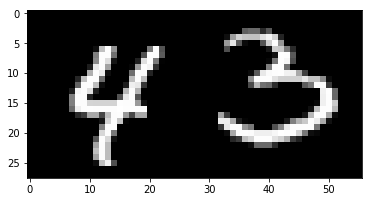

In [67]:
plt.imshow(test)

In [73]:
test[:,:,0].shape

(28, 56)

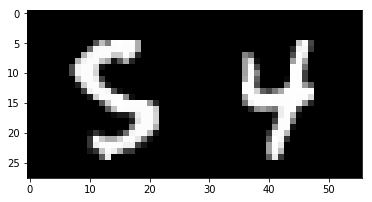

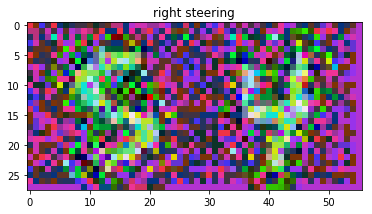

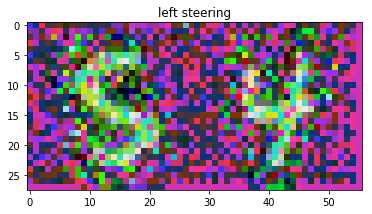

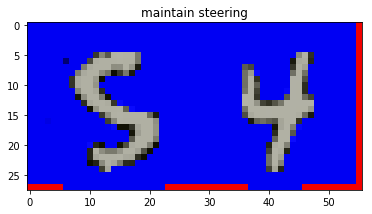

In [84]:
idx = 999

three_dim = np.zeros((28,56,3))

three_dim[:,:,0] = X_test[idx].reshape((28,56))
three_dim[:,:,1] = X_test[idx].reshape((28,56))
three_dim[:,:,2] = X_test[idx].reshape((28,56))

plt.imshow(three_dim)

titles = ['right steering', 'left steering', 'maintain steering']
modifiers = [None, 'negate', 'small_values']

for i, modifier in enumerate(modifiers):
    heatmap = visualize_saliency(model, layer_idx=-1, filter_indices=0, 
                                 seed_input=three_dim[:,:,0].reshape((28,56,1)), grad_modifier=modifier)
    plt.figure()
    plt.title(titles[i])
    plt.imshow(overlay(three_dim, heatmap, alpha=0.7))

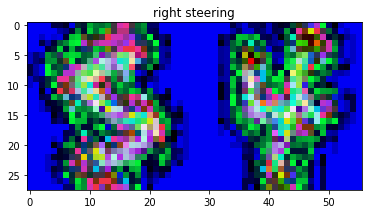

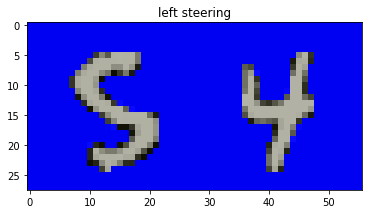

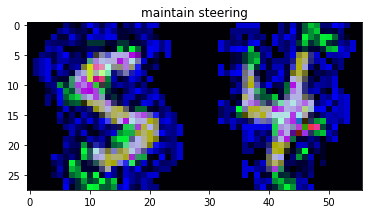

In [85]:
from vis.visualization import visualize_cam

for i, modifier in enumerate(modifiers):
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
                            seed_input=three_dim[:,:,0].reshape((28,56,1)), grad_modifier=modifier)
    plt.figure()
    plt.title(titles[i])
    # Overlay is used to alpha blend heatmap onto img.
    plt.imshow(overlay(three_dim, heatmap, alpha=0.7))

## END

In [67]:
len(test_set_pairs)

10

In [60]:
unique_pairs = np.asarray(unique_pairs)

In [61]:
unique_pairs[test_index]

array(['01', '18', '34', '36', '38', '43', '44', '45', '54', '91'],
      dtype='|S2')

In [10]:
# Ensure there are 90 training set pairs and 10 test set pairs
assert(len(test_set_pairs) == 10)
assert(len(train_set_pairs) == 90)

# Ensure no test set pairs appear in the training set pairs:
for test_set in test_set_pairs:
    assert(test_set not in train_set_pairs)

EXPERIMENT: Train and test with the same permutations.

With our permutation pairs, we can begin generating the data.

We use the `train_set_pairs` and `test_set_pairs` arrays as indices to generate data, and in the example below we create 1000 samples for each test and train set permutation pair. So, there are for example exactly 1000 samples for every premutation, resulting in 100,000 images in total split 90/10 across the train set and test set:

In [11]:
X_train = []
y_train = []

# Number of samples per permutation (e.g. there are 90 permutations in the train set so 3000 * 90)
samples_per_permutation = 1000  

for train_set_pair in train_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_train_keras == int(train_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_train_keras == int(train_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_train_keras[rand_i]
        temp_image[:,28:] = X_train_keras[rand_j]

        X_train.append(temp_image)
        y_train.append(y_train_keras[rand_i] + y_train_keras[rand_j])
        
X_test = []
y_test = []

for test_set_pair in test_set_pairs:
    for _ in range(samples_per_permutation):
        rand_i = np.random.choice(np.where(y_test_keras == int(test_set_pair[0]))[0])
        rand_j = np.random.choice(np.where(y_test_keras == int(test_set_pair[1]))[0])
        
        temp_image = np.zeros((28,56), dtype="uint8")
        temp_image[:,:28] = X_test_keras[rand_i]
        temp_image[:,28:] = X_test_keras[rand_j]
            
        X_test.append(temp_image)
        y_test.append(y_test_keras[rand_i] + y_test_keras[rand_j])

In the code above, we also generate our labels, which are the sum of the two images contained in each generated image. 

First, however, we will ensure we have generated the number of images is correct and that the label data matches the image data sizes:

In [12]:
len(X_train)

90000

In [13]:
# The training set should be 90,000 images in size (90 permutations * 1000)
# and the label data, y_train, must also be equal in length.
assert(len(X_train) == samples_per_permutation * 90)
assert(len(X_train) == len(y_train))

# The test set should be 10,000 images in size (10 permutations * 1000)
# and the label data, y_test, must also be equal in length
assert(len(X_test) == samples_per_permutation * 10)
assert(len(X_test) == len(y_test))

Let us also preview a generated image and its label so that we get an understanding of how the dataset looks:

In [14]:
ind = random.randint(0, len(X_test))
print("Image label: " + str(y_test[ind]))
Image.fromarray(X_test[ind])

Image label: 14


As you can see, each image sample consists of two MNIST images side by side, with each digit taken at random from the entire set of possible 3s in the MNIST data set. The image's label is the addition of the the two numbers.

We can examine the frequency of the labels for the training and test set data also:

In [15]:
print("Test set:")
print(itemfreq(y_test))
print("Training set:")
print(itemfreq(y_train))

Test set:
[[   2 1000]
 [   3 1000]
 [   6 1000]
 [   7 1000]
 [   9 1000]
 [  10 1000]
 [  11 1000]
 [  14 1000]
 [  16 1000]
 [  17 1000]]
Training set:
[[   0 1000]
 [   1 2000]
 [   2 2000]
 [   3 3000]
 [   4 5000]
 [   5 6000]
 [   6 6000]
 [   7 7000]
 [   8 9000]
 [   9 9000]
 [  10 8000]
 [  11 7000]
 [  12 7000]
 [  13 6000]
 [  14 4000]
 [  15 4000]
 [  16 2000]
 [  17 1000]
 [  18 1000]]


There are more images that sum to 7,8,9,10,11 and so on for obvious reasons.

What is important to note is that the network will be trained on 90 of the possible 100 permutations of the digits 0-9, and hence when tested will never have seen those permutations before. As we saw above, the `test_set_pairs` array contains 10 permuations that will never be seen during training.

Finally, we will prepare the data for input into the network:

In [16]:
# Ensure we are using NumPy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Reshape the data sets to a format suitable for Keras
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Reformat the images to use floating point values rather than integers between 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Shuffling the data is always good practice:

In [17]:
X_train, y_train = utils.shuffle(X_train, y_train)
X_test, y_test = utils.shuffle(X_test, y_test)

## Training the Neural Network

A very similar network to that used in the seminal LeNet5 experiment is used, except that we will be training this network as a regression problem rather than a classification problem. More on this later.

In [18]:
######################################################
# Set up a few constants related to the size of the 
# network, number of output classes and so on.
batch_size = 128
# This is a regression problem and we will 
# use a single neuron as output: this network is not 
# being trained as a classification problem.
num_classes = 1               
epochs = 100
img_rows, img_cols = np.shape(X_train)[1], np.shape(X_train)[2]
input_shape = (img_rows, img_cols, 1)


######################################################
# Set up the network itself
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))  # Default is (3, 3)
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # Default is 128
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
# Do not use softmax here, just specify one nueron
model.add(Dense(num_classes, activation='linear')) # CHANGED TO LINEAR, REMOVE TO GO BACK TO DEFAULT


######################################################
# Choose an optimiser and configure it.
# Here we have initialised a number of optimisers, but 
# we will use Root Mean Squared Propagation (RMSprop)
rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
sgd = optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)


######################################################
# Compile the network.
# Note: As this is a regression problem, only mean squared error 
# or mean absolute error can be used for the loss.
model.compile(loss=losses.mean_squared_error, optimizer=ada)

## Network Tests

Some experiments. ** DO NOT RUN NOW**

In [ ]:
input_shape = (img_rows * img_cols)

X_train = X_train.reshape(len(X_train), 28*56)
X_test = X_test.reshape(len(X_test), 28*56)


model = Sequential()
model.add(Dense(2000, input_shape=(28*56, ), activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes))

rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
sgd = optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9, nesterov=True)
ada = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
ndm = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

model.compile(loss=losses.mean_absolute_error, optimizer=ndm)

Now we are ready to train the network. This will take some time, especially if you are not using a GPU.

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 26s 285us/step - loss: 7.5706 - val_loss: 4.3498
Epoch 2/100
90000/90000 [==============================] - 17s 184us/step - loss: 3.9056 - val_loss: 4.9889
Epoch 3/100
90000/90000 [==============================] - 17s 187us/step - loss: 3.0883 - val_loss: 5.9190
Epoch 4/100
90000/90000 [==============================] - 17s 190us/step - loss: 2.5739 - val_loss: 19.7419
Epoch 5/100
90000/90000 [==============================] - 16s 183us/step - loss: 2.2252 - val_loss: 19.7223
Epoch 6/100
90000/90000 [==============================] - 16s 182us/step - loss: 1.9645 - val_loss: 18.3465
Epoch 7/100
90000/90000 [==============================] - 17s 184us/step - loss: 1.7629 - val_loss: 26.4703
Epoch 8/100
90000/90000 [==============================] - 17s 184us/step - loss: 1.5743 - val_loss: 21.9779
Epoch 9/100
90000/90000 [==============================] - 17s 184us/step - loss:

We can print the network's score:

In [13]:
score = model.evaluate(X_test, y_test, verbose=1)
print("\n%.5f" % score)

10000/10000 [==============================] - 2s 182us/step

0.55562


**Optional: You may want to save the model and weights for later use.**

In [8]:
model.save("/home/marcus/mnistcalc_model_best.h5")
model.save_weights("/home/marcus/mnistcalc_weights_best.h5")

And plot the loss on the training set and test to get an overview:

In [11]:
histories[9]

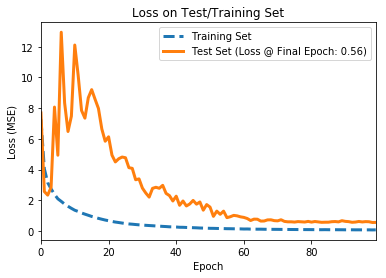

In [15]:
history = histories[9] % for 10 fold.
plt.xlim(0,len(history.history['loss'])-1)
plt.plot(history.history['loss'], linestyle='--', linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('Loss on Test/Training Set')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set (Loss @ Final Epoch: '+ str("%.2f"%score) +')'], loc='upper right')
plt.savefig("/tmp/loss-100-epochs-10fold-title.pdf")
plt.show()

Now we can select random images from the test set, and see how well the network predicts their summation:

In [19]:
for _ in range(10):
    ind = random.randint(0, len(X_test)-1)
    image_predicted = X_test[ind].copy()
    image_predicted = image_predicted.reshape((28, 56))
    image_predicted = image_predicted * 255
    image_predicted = image_predicted.astype('uint8')
    dp.display_png(Image.fromarray(image_predicted))
    p = model.predict(X_test[ind].reshape(1, 28, 56, 1))[0][0]
    print("Prediction for index %s: %s (Actual: %s)" % (ind, p, y_test[ind]))

Prediction for index 3671: 7.46396 (Actual: 8)


Prediction for index 8536: 7.09811 (Actual: 7)


Prediction for index 8823: 1.5383 (Actual: 1)


Prediction for index 6644: 6.38974 (Actual: 7)


Prediction for index 2864: 9.88649 (Actual: 9)


Prediction for index 862: 7.86016 (Actual: 8)


Prediction for index 1898: 11.4764 (Actual: 11)


Prediction for index 9103: 11.3635 (Actual: 11)


Prediction for index 7790: 6.76048 (Actual: 7)


Prediction for index 84: 7.11598 (Actual: 7)


## Evaluation of Accuracy

Evaluating the accuracy of the model can also be done by rounding the predicted values to the nearest integer and comparing these to the actual labels:

In [32]:
correct = 0
incorrect = 0

for i in range(0, len(y_test)):
    prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]
    rounded_prediction = round(prediction)
    floor_prediction = floor(prediction)
    ceiling_prediction = ceil(prediction)
    
    abs_difference = abs(rounded_prediction-y_test[i])
    
    if abs_difference <= 1:
        correct = correct + 1
    else:
        incorrect = incorrect + 1
        
print("Correct: %s, incorrect: %s" % (correct, incorrect))

Correct: 8517, incorrect: 1483


In [28]:
correct

8517

In [20]:
correct = 0
incorrect = 0

for i in range(0, len(y_test)):
    prediction = model.predict(X_test[i].reshape(1, X_test[i].shape[0], X_test[i].shape[1], 1))[0][0]
    rounded_prediction = round(prediction)
    
    if rounded_prediction == y_test[i]:
        correct += 1
    else:
        incorrect += 1

print("Correct: %s, incorrect: %s" % (correct, incorrect))

Correct: 6235, incorrect: 3765


## Examine the Layers for their Properties

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
layer_dict

Now we examine a single filter (index 0) of the layer conv2d_1:

## Evaluating the Network

To really perform a good sanity test, it is best to test the network on the **training set** so that we know we are learning a model that can predict:

In [ ]:
_training_set_score = model.evaluate(X_train, y_train)
print("\n%.5f" % _training_set_score)

See how well the network performs per correct sum:

In [ ]:
correct = 0

for _ in range(len(X_test)):
    p = model.predict(X_test[_].reshape(1, X_test[_].shape[0], X_test[_].shape[1], 1))[0][0]
    #if floor(p) == y_test[_] or ceil(p) == y_test[_]:
    #    correct += 1
    if round(p) == y_test[_]:
        correct += 1

print(str(correct) + " of " + str(len(X_test)))

In [ ]:
correct / float(len(X_test)) * 100

See how well the network performs for each label:

In [ ]:
freq = itemfreq(y_test)
test_set_labels = []
for f in freq:
    test_set_labels.append(f[0])

correct_by_label = dict()

for l in test_set_labels:
    correct_by_label[l] = 0

for test_set_label in test_set_labels:
    for _ in range(len(X_test)):
        if y_test[_] == test_set_label:
            p = model.predict(X_test[_].reshape(1, X_test[_].shape[0], X_test[_].shape[1], 1))[0][0]
            if round(p) == y_test[_]:
                correct_by_label[test_set_label] += 1

correct_by_label

## Visualising the Network

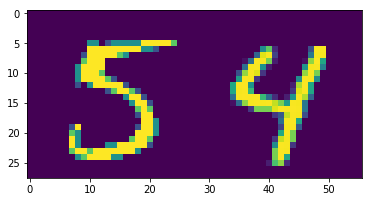

In [33]:
# Plot using matplotlib, as we can use heat maps later for the saliency maps.

idx = 9999

plt.imshow(X_test[idx][..., 0])

In [34]:
_ = 9999
model.predict(X_test[_].reshape(1, X_test[_].shape[0], X_test[_].shape[1], 1))[0][0]

9.5657711

In [35]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 26, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19968)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5112064   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [37]:
# Get the last layer:
layer_idx = utils.find_layer_idx(model, 'dense_3')

In [38]:
# Swap out the last layer with a linear activation function rather than a sigmoid (it is not a sigmoid anyway)
model.layers[layer_idx].activation = activations.linear

In [39]:
# Apply this
model = utils.apply_modifications(model)

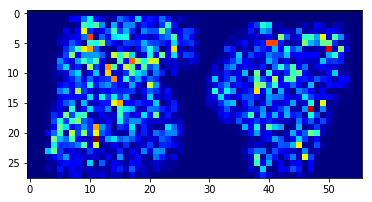

In [40]:
grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

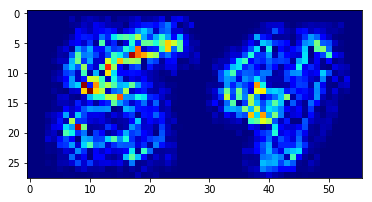

In [41]:
grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X_test[idx], backprop_modifier='guided')
plt.imshow(grads, cmap='jet')

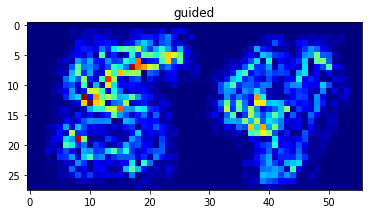

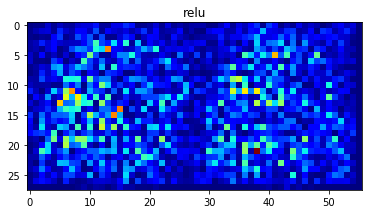

In [42]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=0,
                               seed_input=X_test[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

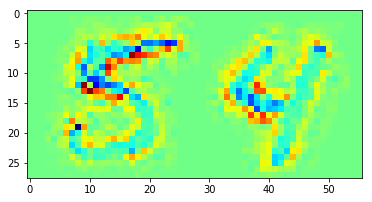

In [43]:
grads = visualize_saliency(model, layer_idx, filter_indices=0, seed_input=X_test[idx], 
                           backprop_modifier='guided', grad_modifier='negate')
plt.imshow(grads, cmap='jet')

# Test

In [ ]:
model.summary()

In [ ]:
from vis.visualization import visualize_activation

In [ ]:
img = visualize_activation(model, layer_idx, filter_indices=0)
plt.imshow(img.reshape((28,56)))

In [ ]:
img = visualize_activation(model, layer_idx, filter_indices=0, max_iter=500, verbose=True)

In [ ]:
plt.imshow(img.reshape((28,56)))

In [ ]:
from vis.visualization import get_num_filters

In [ ]:
layer_name = 'conv2d_2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))
    img = img.reshape((28,56))
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
img.shape